In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Analysis of the performance of each input encoding method

Here, we test 4 different input encoding techniques:
- Continuous Encoding: We apply the arctan to every feature to scale it to be bewteen [$-\pi/2,\pi/2$].
- Scaled-Continuous Encoding: We apply continuous encoding to the 2 unbounded features and scale the two bounded features to be between [$0,2\pi$]
- Scaled-Continuous Encoding V2: It's the same as the SC encoding explained previously but now we consider the fact that the domain of the bounded features is not actually as explained in the OpenAI Gym envirnoment. More specifically, it is stated that the Cart Position feature is between [$-4.8,4.8$], but in reality it ends up being [$-2.4,2.4$], because if the value falls out of those bounds, the episode terminates. A similar situation occurs in the Pole Angle feature of the state.
- Nothing encoding: The feature values are fed to the VQC as they are, without any classical pre-processing.

After one of these techniques is applied, the features are fed to the VQC, which then applies an RX rotation.

For each Input Encoding technique, we trained 5 models each for the baseline model (no data re-uploading), Data Re-uploadingV1 models and Data re-uploading V2 models. All of these models were trained using the optimal hyperparameters used by Skolik in her paper.

In [2]:
# Let's start by loading the data

#The lists that will contain the 5 agents for each combination of Input Encoding and Data Re-uploading technique
c_v0 = []
c_v1 = []
c_v2 = []
sc_v0 = []
sc_v1 = []
sc_v2 = []
scv2_v0 = []
scv2_v1 = []
scv2_v2 = []
n_v0 = []
n_v1 = []
n_v2 = []

#Load the models trained using continuous input encoding

for i in range(1,6):
    with open(f'Results/continuous/skolik_arch/baseline/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper/agent{i}.pkl', 'rb') as f:
        c_v0.append(pickle.load(f))

for i in range(1,6):
    with open(f'Results/continuous/skolik_arch/basic_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper/agent{i}.pkl', 'rb') as f:
        c_v1.append(pickle.load(f))

for i in range(1,6):
    with open(f'Results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper/agent{i}.pkl', 'rb') as f:
        c_v2.append(pickle.load(f))

#Load the models trained using scaled continuous input encoding

for i in range(1,6):
    with open(f'Results/scaled_continuous/skolik_arch/baseline/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper/agent{i}.pkl', 'rb') as f:
        sc_v0.append(pickle.load(f))

for i in range(1,6):
    with open(f'Results/scaled_continuous/skolik_arch/basic_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper/agent{i}.pkl', 'rb') as f:
        sc_v1.append(pickle.load(f))

for i in range(1,6):
    with open(f'Results/scaled_continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper/agent{i}.pkl', 'rb') as f:
        sc_v2.append(pickle.load(f))

## 1.1) Analysis of the Performance of the Models

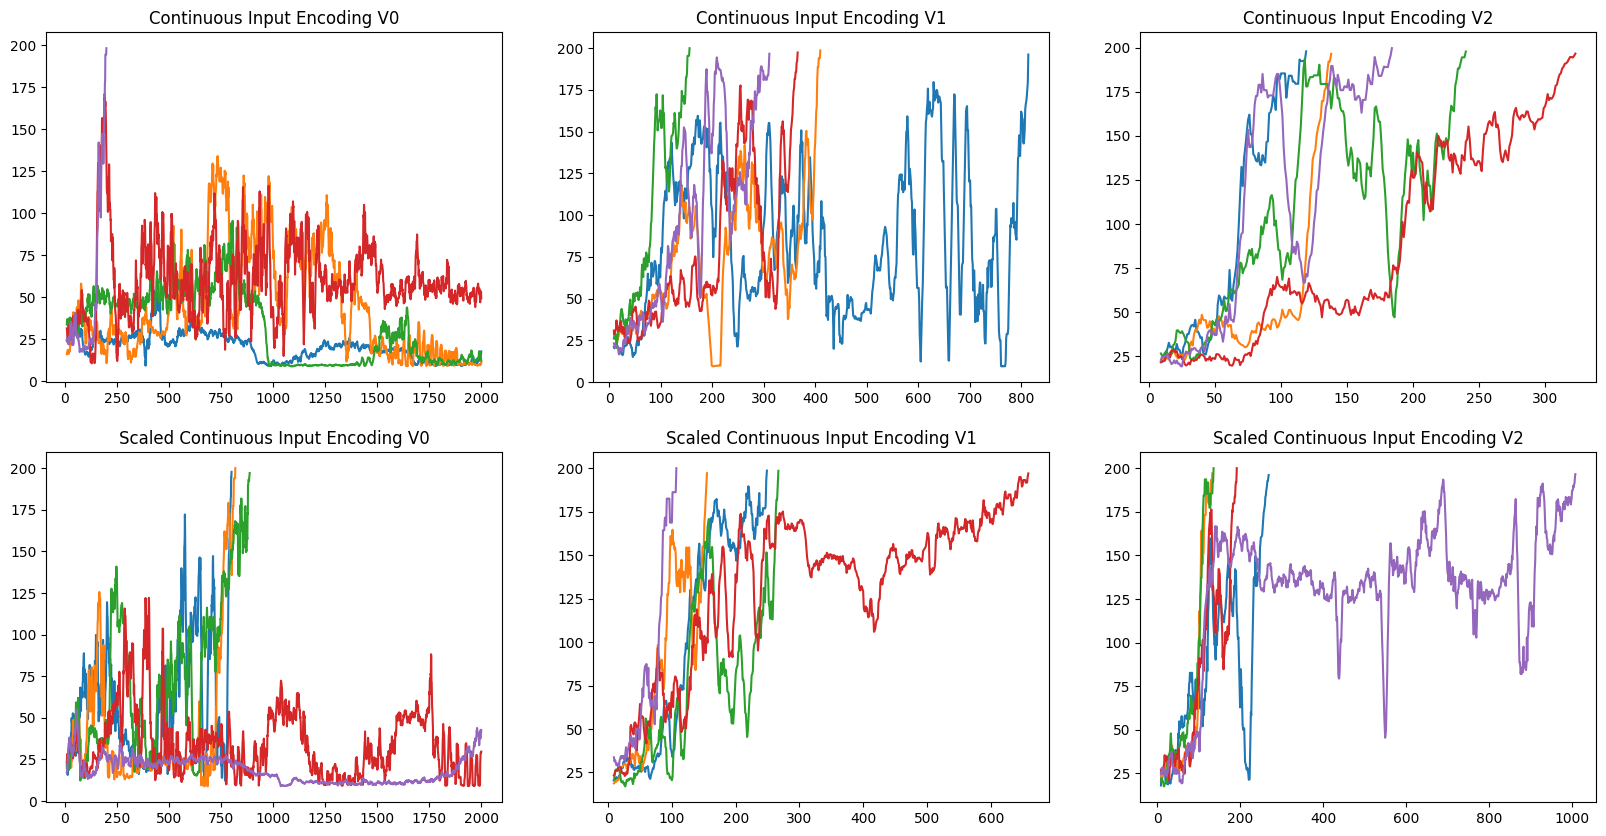

In [4]:
#Let's plot the moving average of the rewards for each agent

fig, axs = plt.subplots(2,3, figsize=(20,10))

for i in range(5):
    axs[0,0].plot(pd.Series(c_v0[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[0,1].plot(pd.Series(c_v1[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[0,2].plot(pd.Series(c_v2[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[1,0].plot(pd.Series(sc_v0[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[1,1].plot(pd.Series(sc_v1[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")
    axs[1,2].plot(pd.Series(sc_v2[i]["episode_reward_history"]).rolling(10).mean(), label = f"Agent {i+1}")

axs[0,0].set_title("Continuous Input Encoding V0")
axs[0,1].set_title("Continuous Input Encoding V1")
axs[0,2].set_title("Continuous Input Encoding V2")
axs[1,0].set_title("Scaled Continuous Input Encoding V0")
axs[1,1].set_title("Scaled Continuous Input Encoding V1")
axs[1,2].set_title("Scaled Continuous Input Encoding V2")

plt.show()


It seems like Nothing Encoding and Continuous Encoding perform better than the other types of encoding, specially if we consider only the V2 models. However, to make sure that is the case, we need to perform a statistical test. Just 5 agents isn't enough to prove that to be true, so I will run each one of these agents 10 times up to a 1000 episodes. Not only that, I will also do the same for the Scaled Continuous input encoding. It's weird that Nothing encoding performs as good as it does.

## 1.2) Analysis of the Gradients of the Weights of the models that use continuous encoding

In [6]:
#And the gradients of the V0, V1 and V2 models for the Continuous Input encoding
cv0_gradients = [c_v0[i]["gradients"] for i in range(5)]
cv1_gradients = [c_v1[i]["gradients"] for i in range(5)]
cv2_gradients = [c_v2[i]["gradients"] for i in range(5)]

### 1.2.1) Analysis of the Gradients of one of the output Weights

In [7]:
cv0_gradients_output = []
cv1_gradients_output = []
cv2_gradients_output = []
aux = []

for i in range(5):
    for j in range(len(cv0_gradients[i])):
        aux.append(abs(cv0_gradients[i][j][1][0][0]))
    cv0_gradients_output.append(aux)
    aux = []

for i in range(5):
    for j in range(len(cv1_gradients[i])):
        aux.append(abs(cv1_gradients[i][j][2][0][0]))
    cv1_gradients_output.append(aux)
    aux = []

for i in range(5):
    for j in range(len(cv2_gradients[i])):
        aux.append(abs(cv2_gradients[i][j][2][0][0]))
    cv2_gradients_output.append(aux)
    aux = []

In [8]:
# Now let's take each list and calculate the mean and the variance of the gradients at every training step

cv0_gradients_output_counts = [len(cv0_gradients_output[i]) for i in range(5)]
cv0_gradients_output_min = min(cv0_gradients_output_counts)

cv0_gradients_output_mean = []
cv0_gradients_output_std = []
aux_mean = []

for i in range(cv0_gradients_output_min):
    for j in range(5):
        aux_mean.append(cv0_gradients_output[j][i])
    cv0_gradients_output_mean.append(np.mean(aux_mean))
    cv0_gradients_output_std.append(np.std(aux_mean))
    aux_mean = []

cv1_gradients_output_counts = [len(cv1_gradients_output[i]) for i in range(5)]
cv1_gradients_output_min = min(cv1_gradients_output_counts)

cv1_gradients_output_mean = []
cv1_gradients_output_std = []
aux_mean = []

for i in range(cv1_gradients_output_min):
    for j in range(5):
        aux_mean.append(cv1_gradients_output[j][i])
    cv1_gradients_output_mean.append(np.mean(aux_mean))
    cv1_gradients_output_std.append(np.std(aux_mean))
    aux_mean = []

cv2_gradients_output_counts = [len(cv2_gradients_output[i]) for i in range(5)]
cv2_gradients_output_min = min(cv2_gradients_output_counts)

cv2_gradients_output_mean = []
cv2_gradients_output_std = []
aux_mean = []

for i in range(cv2_gradients_output_min):
    for j in range(5):
        aux_mean.append(cv2_gradients_output[j][i])
    cv2_gradients_output_mean.append(np.mean(aux_mean))
    cv2_gradients_output_std.append(np.std(aux_mean))
    aux_mean = []


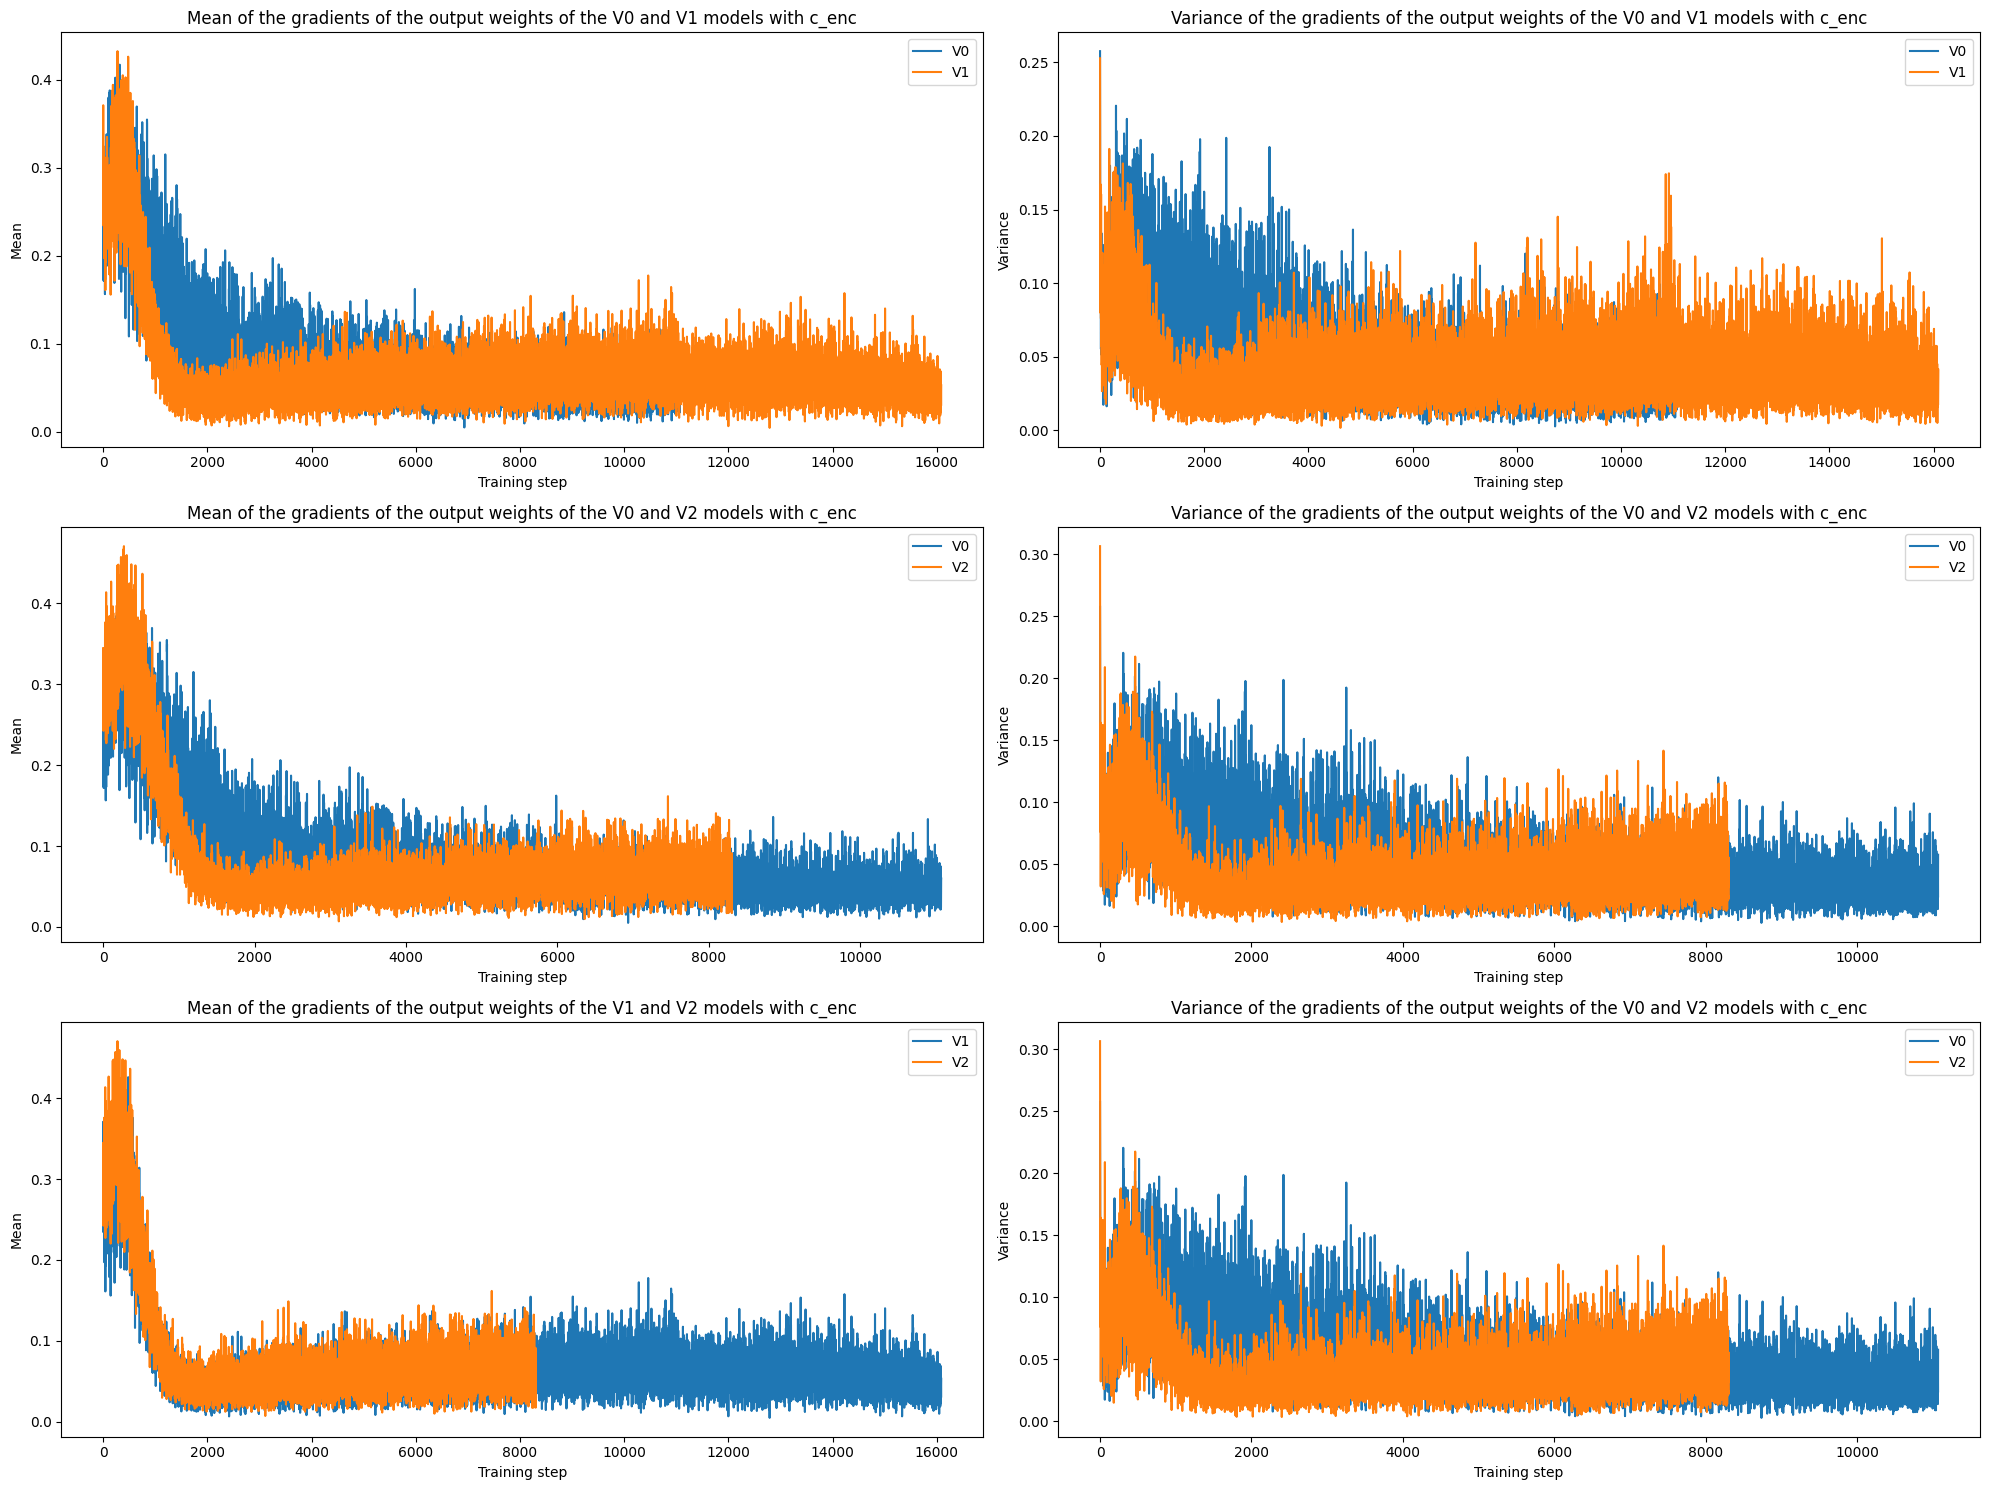

In [9]:
#Now let's plot the mean and variance of the gradients for the V0, V1 and V2 models in the same plot

fig, axs = plt.subplots(3,2, tight_layout=True, figsize=(20, 15))

axs[0,0].set_title("Mean of the gradients of the output weights of the V0 and V1 models with c_enc")
axs[0,0].set_xlabel("Training step")
axs[0,0].set_ylabel("Mean")
axs[0,0].plot(cv0_gradients_output_mean, label = "V0")
axs[0,0].plot(cv1_gradients_output_mean, label = "V1")
axs[0,0].legend()

axs[0,1].set_title("Variance of the gradients of the output weights of the V0 and V1 models with c_enc")
axs[0,1].set_xlabel("Training step")
axs[0,1].set_ylabel("Variance")
axs[0,1].plot(cv0_gradients_output_std, label = "V0")
axs[0,1].plot(cv1_gradients_output_std, label = "V1")
axs[0,1].legend()



axs[1,0].set_title("Mean of the gradients of the output weights of the V0 and V2 models with c_enc")
axs[1,0].set_xlabel("Training step")
axs[1,0].set_ylabel("Mean")
axs[1,0].plot(cv0_gradients_output_mean, label = "V0")
axs[1,0].plot(cv2_gradients_output_mean, label = "V2")
axs[1,0].legend()

axs[1,1].set_title("Variance of the gradients of the output weights of the V0 and V2 models with c_enc")
axs[1,1].set_xlabel("Training step")
axs[1,1].set_ylabel("Variance")
axs[1,1].plot(cv0_gradients_output_std, label = "V0")
axs[1,1].plot(cv2_gradients_output_std, label = "V2")
axs[1,1].legend()




axs[2,0].set_title("Mean of the gradients of the output weights of the V1 and V2 models with c_enc")
axs[2,0].set_xlabel("Training step")
axs[2,0].set_ylabel("Mean")
axs[2,0].plot(cv1_gradients_output_mean, label = "V1")
axs[2,0].plot(cv2_gradients_output_mean, label = "V2")
axs[2,0].legend()

axs[2,1].set_title("Variance of the gradients of the output weights of the V0 and V2 models with c_enc")
axs[2,1].set_xlabel("Training step")
axs[2,1].set_ylabel("Variance")
axs[2,1].plot(cv0_gradients_output_std, label = "V0")
axs[2,1].plot(cv2_gradients_output_std, label = "V2")
axs[2,1].legend()

plt.show()

### 1.2.2) Analysis of the gradients of the first parametrized rotation

In [10]:
cv0_gradients_first_parameter = []
cv1_gradients_first_parameter = []
cv2_gradients_first_parameter = []
aux = []

for i in range(5):
    for j in range(len(cv0_gradients[i])):
        aux.append(abs(cv0_gradients[i][j][0][0][0]))
    cv0_gradients_first_parameter.append(aux)
    aux = []

for i in range(5):
    for j in range(len(cv1_gradients[i])):
        aux.append(abs(cv1_gradients[i][j][0][0][0]))
    cv1_gradients_first_parameter.append(aux)
    aux = []

for i in range(5):
    for j in range(len(cv2_gradients[i])):
        aux.append(abs(cv2_gradients[i][j][0][0][0]))
    cv2_gradients_first_parameter.append(aux)
    aux = []

In [11]:
# Now let's take each list and calculate the mean andthe variance of the gradients at every training step

cv0_gradients_first_parameter_counts = [len(cv0_gradients_first_parameter[i]) for i in range(5)]
cv0_gradients_first_parameter_min = min(cv0_gradients_first_parameter_counts)

cv0_gradients_first_parameter_mean = []
cv0_gradients_first_parameter_std = []
aux_mean = []

for i in range(cv0_gradients_first_parameter_min):
    for j in range(5):
        aux_mean.append(cv0_gradients_first_parameter[j][i])
    cv0_gradients_first_parameter_mean.append(np.mean(aux_mean))
    cv0_gradients_first_parameter_std.append(np.std(aux_mean))
    aux_mean = []

cv1_gradients_first_parameter_counts = [len(cv1_gradients_first_parameter[i]) for i in range(5)]
cv1_gradients_first_parameter_min = min(cv1_gradients_first_parameter_counts)

cv1_gradients_first_parameter_mean = []
cv1_gradients_first_parameter_std = []
aux_mean = []

for i in range(cv1_gradients_first_parameter_min):
    for j in range(5):
        aux_mean.append(cv1_gradients_first_parameter[j][i])
    cv1_gradients_first_parameter_mean.append(np.mean(aux_mean))
    cv1_gradients_first_parameter_std.append(np.std(aux_mean))
    aux_mean = []

cv2_gradients_first_parameter_counts = [len(cv2_gradients_first_parameter[i]) for i in range(5)]
cv2_gradients_first_parameter_min = min(cv2_gradients_first_parameter_counts)

cv2_gradients_first_parameter_mean = []
cv2_gradients_first_parameter_std = []
aux_mean = []

for i in range(cv2_gradients_first_parameter_min):
    for j in range(5):
        aux_mean.append(cv2_gradients_first_parameter[j][i])
    cv2_gradients_first_parameter_mean.append(np.mean(aux_mean))
    cv2_gradients_first_parameter_std.append(np.std(aux_mean))
    aux_mean = []


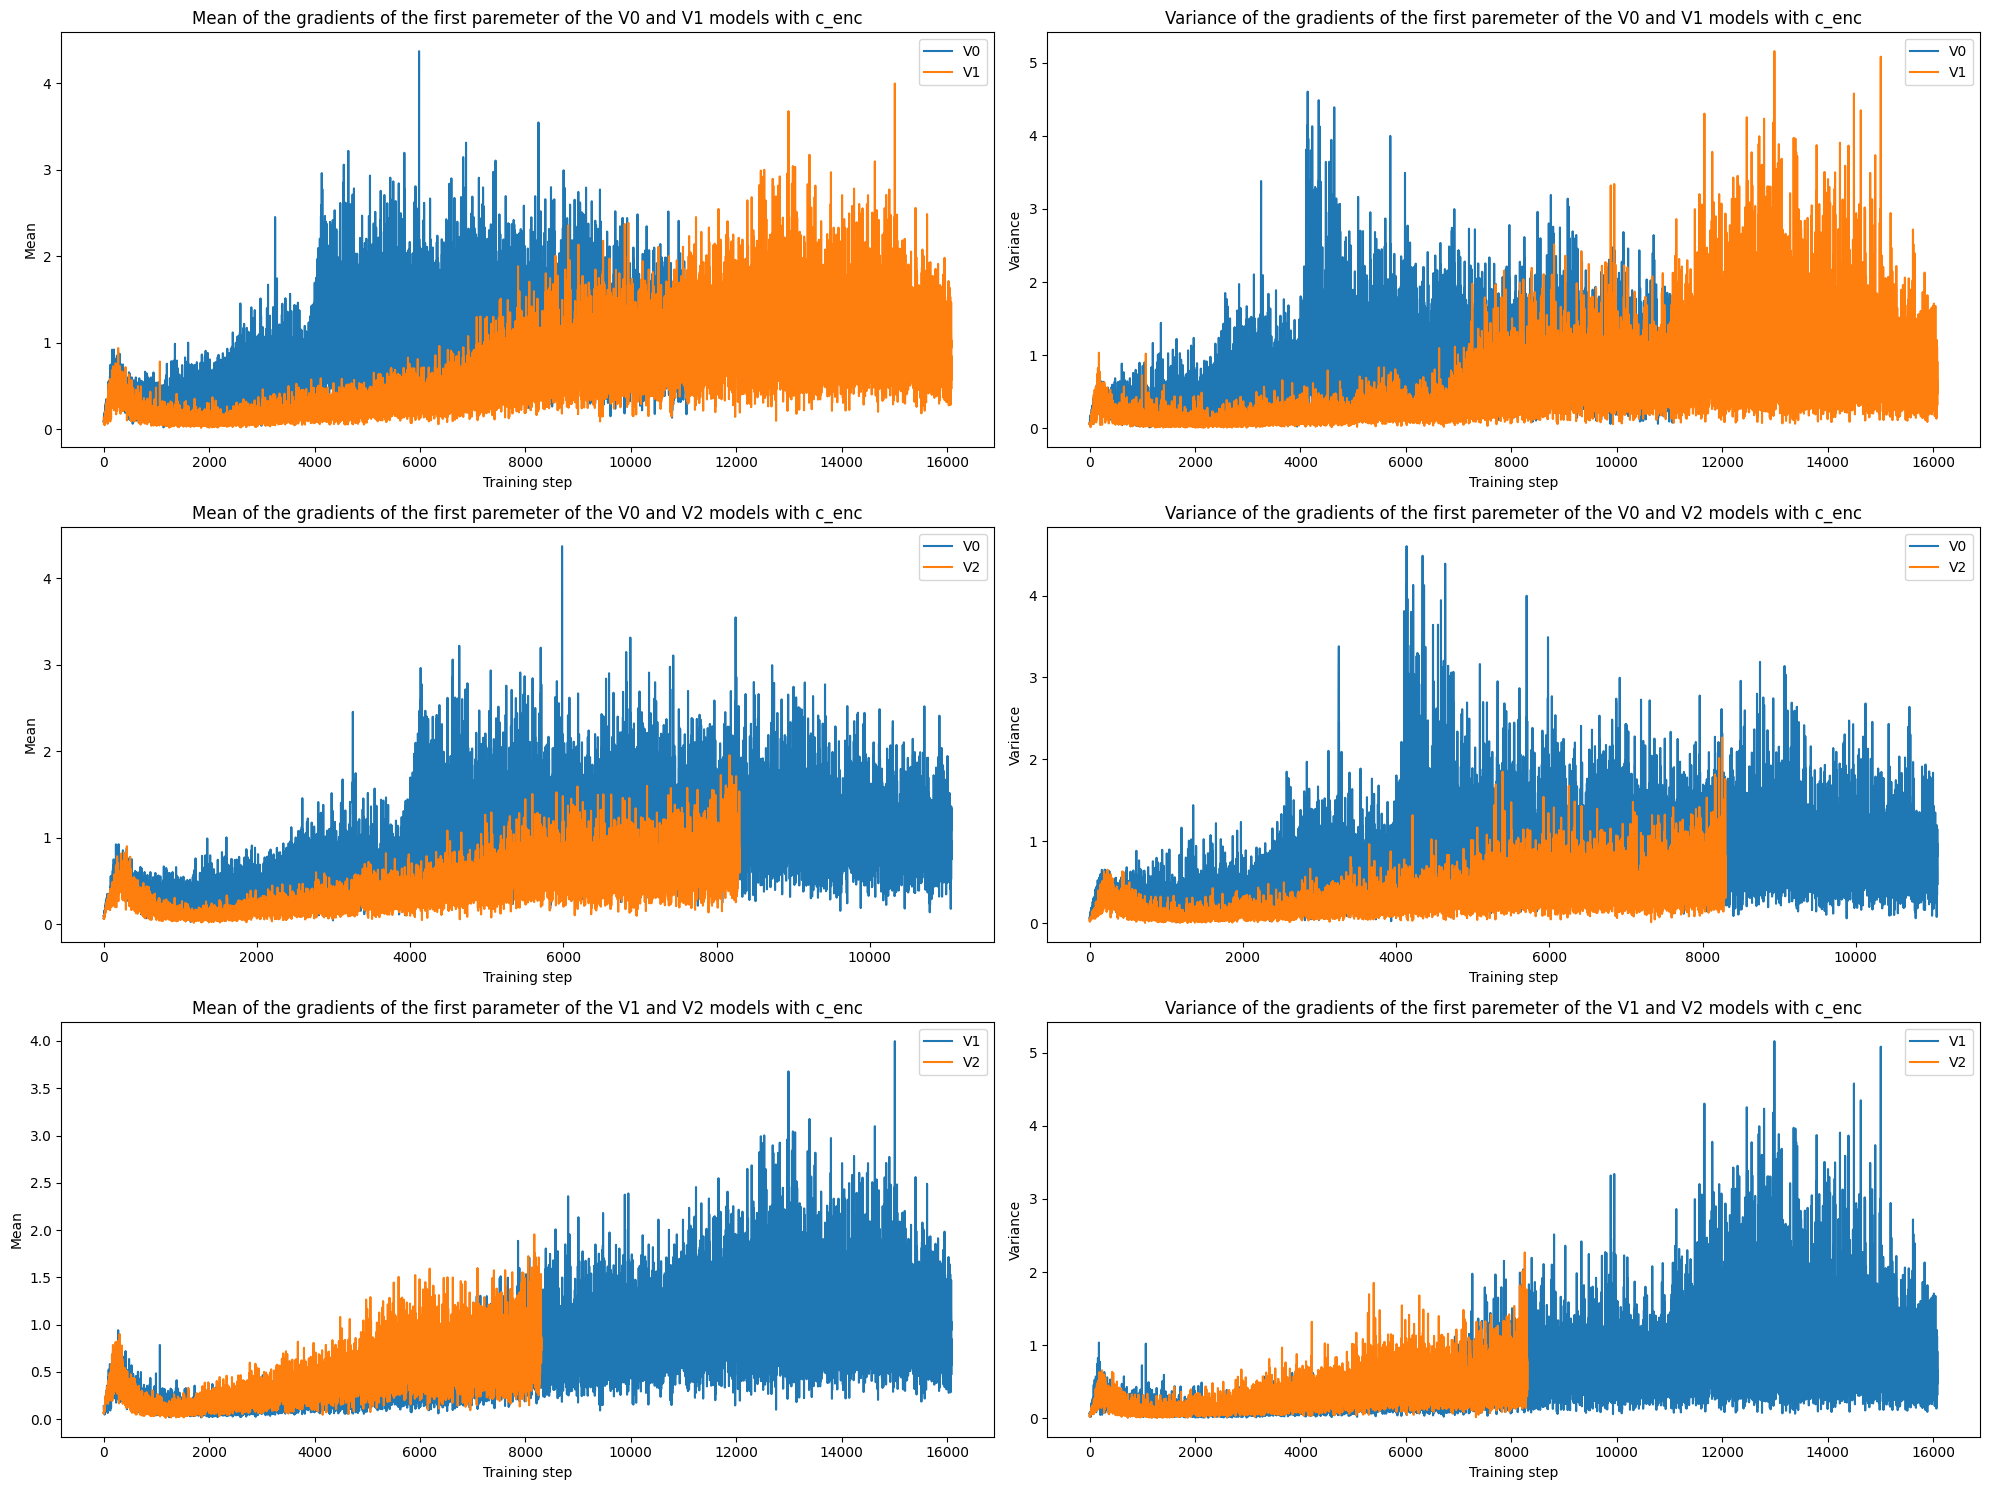

In [12]:
#Now let's plot the mean and variance of the gradients for the V0, V1 and V2 models in the same plot

fig, axs = plt.subplots(3,2, tight_layout=True, figsize=(20, 15))

axs[0,0].set_title("Mean of the gradients of the first paremeter of the V0 and V1 models with c_enc")
axs[0,0].set_xlabel("Training step")
axs[0,0].set_ylabel("Mean")
axs[0,0].plot(cv0_gradients_first_parameter_mean, label = "V0")
axs[0,0].plot(cv1_gradients_first_parameter_mean, label = "V1")
axs[0,0].legend()

axs[0,1].set_title("Variance of the gradients of the first paremeter of the V0 and V1 models with c_enc")
axs[0,1].set_xlabel("Training step")
axs[0,1].set_ylabel("Variance")
axs[0,1].plot(cv0_gradients_first_parameter_std, label = "V0")
axs[0,1].plot(cv1_gradients_first_parameter_std, label = "V1")
axs[0,1].legend()



axs[1,0].set_title("Mean of the gradients of the first paremeter of the V0 and V2 models with c_enc")
axs[1,0].set_xlabel("Training step")
axs[1,0].set_ylabel("Mean")
axs[1,0].plot(cv0_gradients_first_parameter_mean, label = "V0")
axs[1,0].plot(cv2_gradients_first_parameter_mean, label = "V2")
axs[1,0].legend()

axs[1,1].set_title("Variance of the gradients of the first paremeter of the V0 and V2 models with c_enc")
axs[1,1].set_xlabel("Training step")
axs[1,1].set_ylabel("Variance")
axs[1,1].plot(cv0_gradients_first_parameter_std, label = "V0")
axs[1,1].plot(cv2_gradients_first_parameter_std, label = "V2")
axs[1,1].legend()




axs[2,0].set_title("Mean of the gradients of the first parameter of the V1 and V2 models with c_enc")
axs[2,0].set_xlabel("Training step")
axs[2,0].set_ylabel("Mean")
axs[2,0].plot(cv1_gradients_first_parameter_mean, label = "V1")
axs[2,0].plot(cv2_gradients_first_parameter_mean, label = "V2")
axs[2,0].legend()

axs[2,1].set_title("Variance of the gradients of the first paremeter of the V1 and V2 models with c_enc")
axs[2,1].set_xlabel("Training step")
axs[2,1].set_ylabel("Variance")
axs[2,1].plot(cv1_gradients_first_parameter_std, label = "V1")
axs[2,1].plot(cv2_gradients_first_parameter_std, label = "V2")
axs[2,1].legend()

plt.show()

### 1.2.3) Analysis of the gradients of the last parametrized rotation

In [13]:
cv0_gradients_last_parameter = []
cv1_gradients_last_parameter = []
cv2_gradients_last_parameter = []
aux = []

for i in range(5):
    for j in range(len(cv0_gradients[i])):
        aux.append(abs(cv0_gradients[i][j][0][0][-1]))
    cv0_gradients_last_parameter.append(aux)
    aux = []

for i in range(5):
    for j in range(len(cv1_gradients[i])):
        aux.append(abs(cv1_gradients[i][j][0][0][-1]))
    cv1_gradients_last_parameter.append(aux)
    aux = []

for i in range(5):
    for j in range(len(cv2_gradients[i])):
        aux.append(abs(cv2_gradients[i][j][0][0][-1]))
    cv2_gradients_last_parameter.append(aux)
    aux = []

In [14]:
# Now let's take each list and calculate the mean and the variance of the gradients at every training step

cv0_gradients_last_parameter_counts = [len(cv0_gradients_last_parameter[i]) for i in range(5)]
cv0_gradients_last_parameter_min = min(cv0_gradients_last_parameter_counts)

cv0_gradients_last_parameter_mean = []
cv0_gradients_last_parameter_std = []
aux_mean = []

for i in range(cv0_gradients_last_parameter_min):
    for j in range(5):
        aux_mean.append(cv0_gradients_last_parameter[j][i])
    cv0_gradients_last_parameter_mean.append(np.mean(aux_mean))
    cv0_gradients_last_parameter_std.append(np.std(aux_mean))
    aux_mean = []

cv1_gradients_last_parameter_counts = [len(cv1_gradients_last_parameter[i]) for i in range(5)]
cv1_gradients_last_parameter_min = min(cv1_gradients_last_parameter_counts)

cv1_gradients_last_parameter_mean = []
cv1_gradients_last_parameter_std = []
aux_mean = []

for i in range(cv1_gradients_last_parameter_min):
    for j in range(5):
        aux_mean.append(cv1_gradients_last_parameter[j][i])
    cv1_gradients_last_parameter_mean.append(np.mean(aux_mean))
    cv1_gradients_last_parameter_std.append(np.std(aux_mean))
    aux_mean = []

cv2_gradients_last_parameter_counts = [len(cv2_gradients_last_parameter[i]) for i in range(5)]
cv2_gradients_last_parameter_min = min(cv2_gradients_last_parameter_counts)

cv2_gradients_last_parameter_mean = []
cv2_gradients_last_parameter_std = []
aux_mean = []

for i in range(cv2_gradients_last_parameter_min):
    for j in range(5):
        aux_mean.append(cv2_gradients_last_parameter[j][i])
    cv2_gradients_last_parameter_mean.append(np.mean(aux_mean))
    cv2_gradients_last_parameter_std.append(np.std(aux_mean))
    aux_mean = []


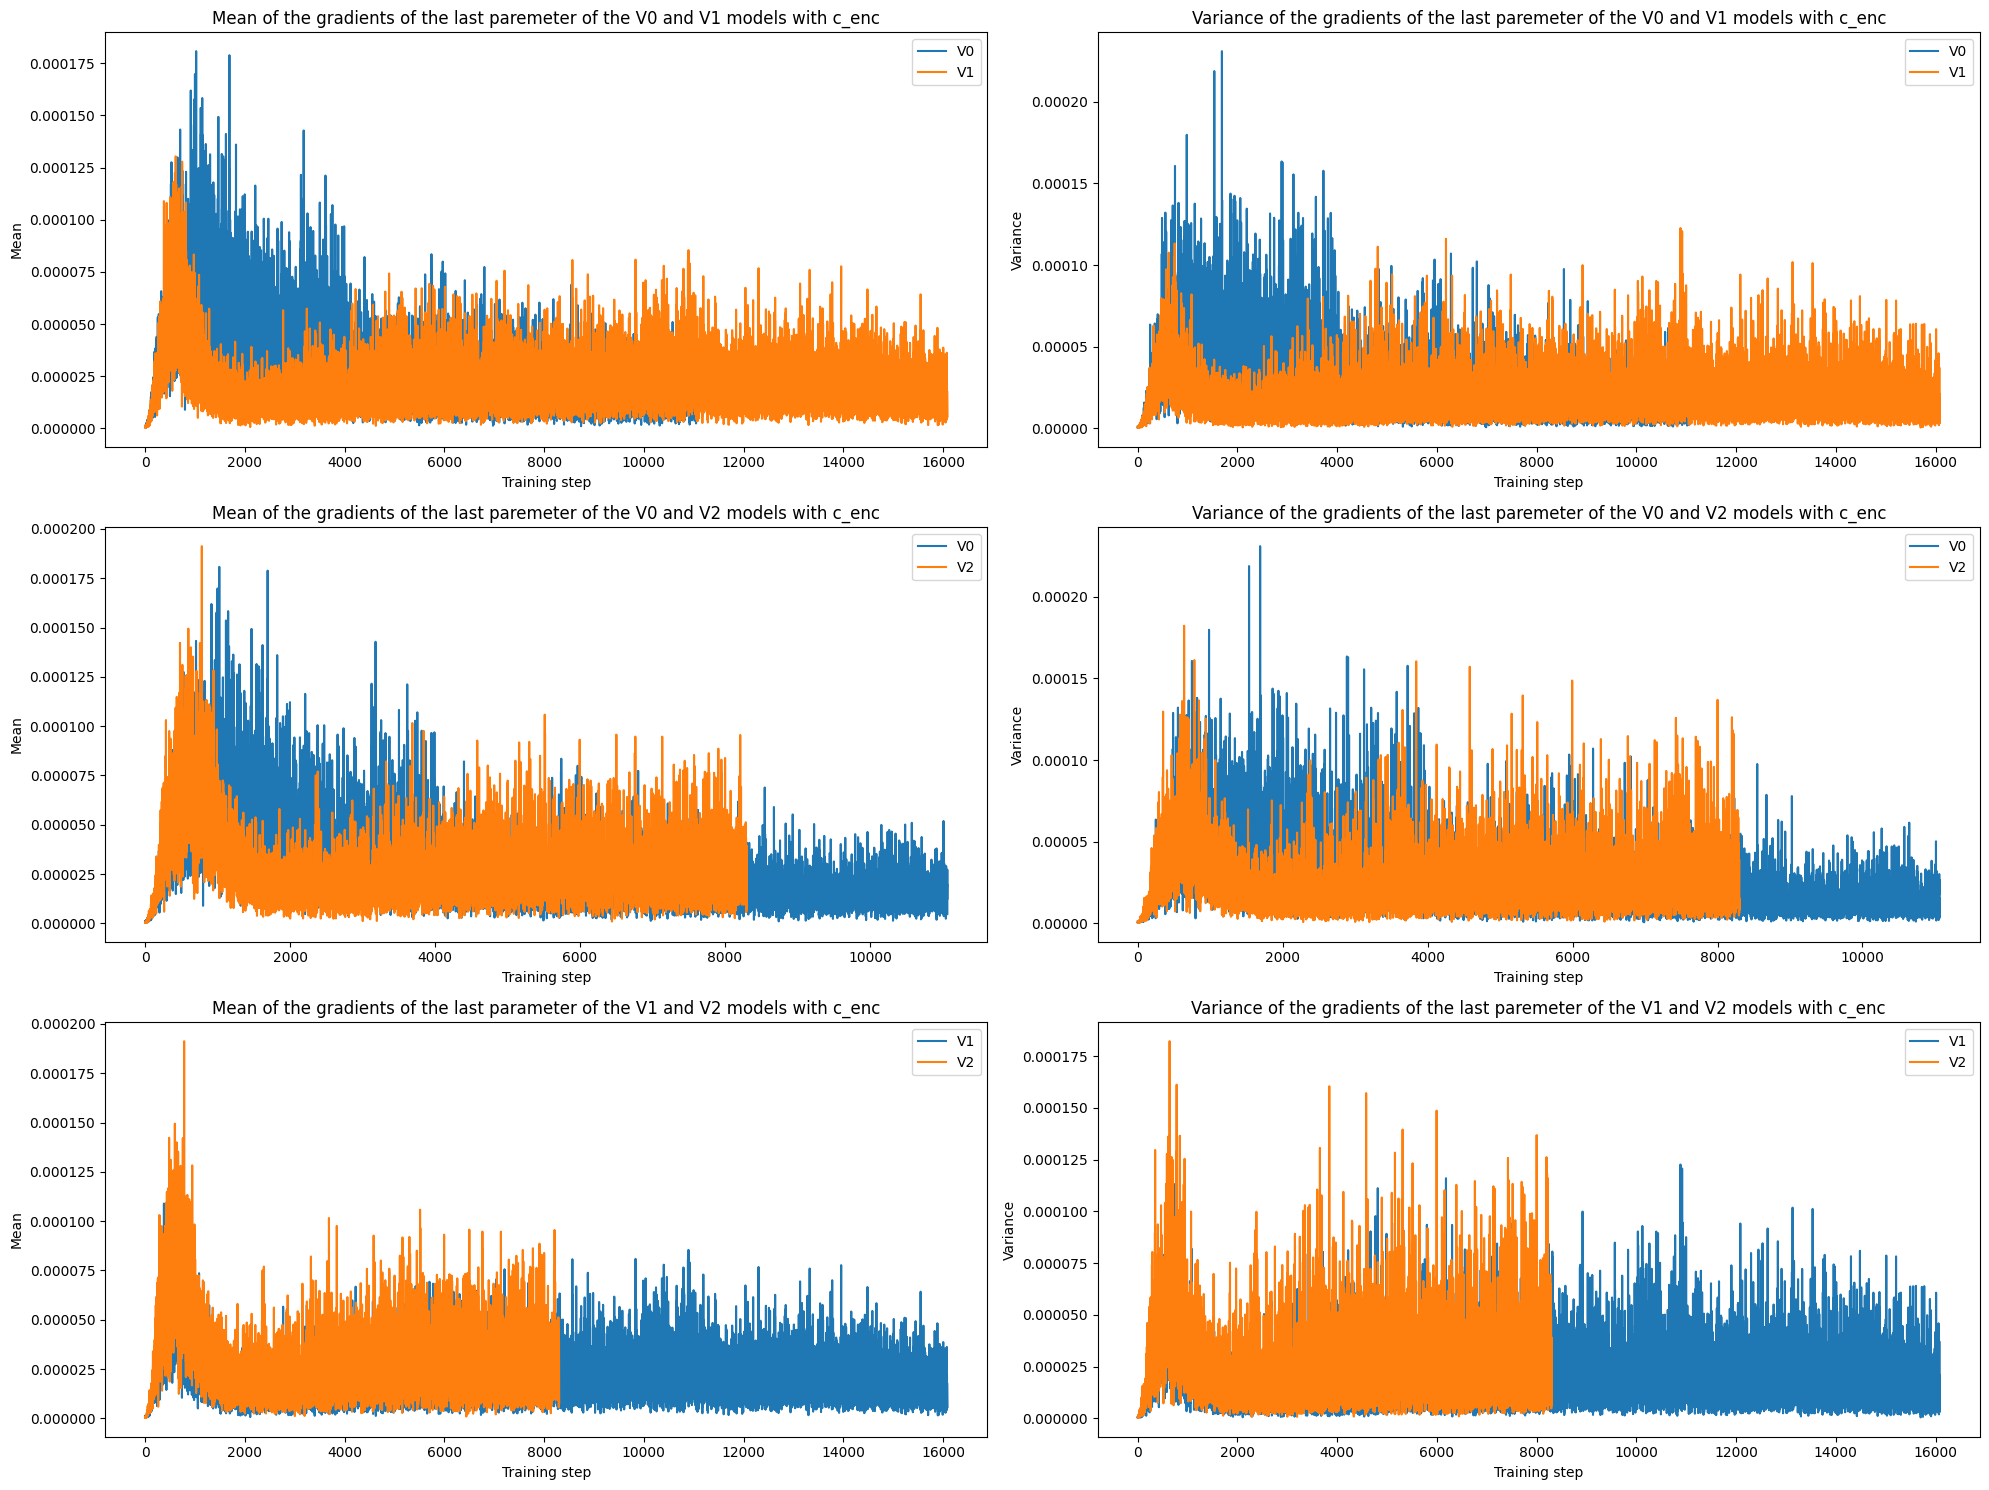

In [15]:
#Now let's plot the mean and variance of the gradients for the V0, V1 and V2 models in the same plot

fig, axs = plt.subplots(3,2, tight_layout=True, figsize=(20, 15))

axs[0,0].set_title("Mean of the gradients of the last paremeter of the V0 and V1 models with c_enc")
axs[0,0].set_xlabel("Training step")
axs[0,0].set_ylabel("Mean")
axs[0,0].plot(cv0_gradients_last_parameter_mean, label = "V0")
axs[0,0].plot(cv1_gradients_last_parameter_mean, label = "V1")
axs[0,0].legend()

axs[0,1].set_title("Variance of the gradients of the last paremeter of the V0 and V1 models with c_enc")
axs[0,1].set_xlabel("Training step")
axs[0,1].set_ylabel("Variance")
axs[0,1].plot(cv0_gradients_last_parameter_std, label = "V0")
axs[0,1].plot(cv1_gradients_last_parameter_std, label = "V1")
axs[0,1].legend()



axs[1,0].set_title("Mean of the gradients of the last paremeter of the V0 and V2 models with c_enc")
axs[1,0].set_xlabel("Training step")
axs[1,0].set_ylabel("Mean")
axs[1,0].plot(cv0_gradients_last_parameter_mean, label = "V0")
axs[1,0].plot(cv2_gradients_last_parameter_mean, label = "V2")
axs[1,0].legend()

axs[1,1].set_title("Variance of the gradients of the last paremeter of the V0 and V2 models with c_enc")
axs[1,1].set_xlabel("Training step")
axs[1,1].set_ylabel("Variance")
axs[1,1].plot(cv0_gradients_last_parameter_std, label = "V0")
axs[1,1].plot(cv2_gradients_last_parameter_std, label = "V2")
axs[1,1].legend()




axs[2,0].set_title("Mean of the gradients of the last parameter of the V1 and V2 models with c_enc")
axs[2,0].set_xlabel("Training step")
axs[2,0].set_ylabel("Mean")
axs[2,0].plot(cv1_gradients_last_parameter_mean, label = "V1")
axs[2,0].plot(cv2_gradients_last_parameter_mean, label = "V2")
axs[2,0].legend()

axs[2,1].set_title("Variance of the gradients of the last paremeter of the V1 and V2 models with c_enc")
axs[2,1].set_xlabel("Training step")
axs[2,1].set_ylabel("Variance")
axs[2,1].plot(cv1_gradients_last_parameter_std, label = "V1")
axs[2,1].plot(cv2_gradients_last_parameter_std, label = "V2")
axs[2,1].legend()

plt.show()

### 1.2.4) Analysis of the gradients of all parametrized rotations

In [16]:
from analysis_functions import Analysis

In [3]:
number_of_agents = 5
path = 'Results/input_encoding/c/'
filename_v0 = 'CartPolev0_Skolik_Arch_v0_ls_optimal_hyper_skolik_outscaling'
filename_v1 = 'CartPolev0_Skolik_Arch_v1_ls_optimal_hyper_skolik_outscaling'
filename_v2 = 'CartPolev0_Skolik_Arch_v2_ls_optimal_hyper_skolik_outscaling'

analysis_v0 = Analysis(path, filename_v0, number_of_agents)
analysis_v1 = Analysis(path, filename_v1, number_of_agents)
analysis_v2 = Analysis(path, filename_v2, number_of_agents)

In [4]:
v0_mean, v0_variance = analysis_v0.get_gradients_all_params()
v1_mean, v1_variance = analysis_v1.get_gradients_all_params()
v2_mean, v2_variance = analysis_v2.get_gradients_all_params()

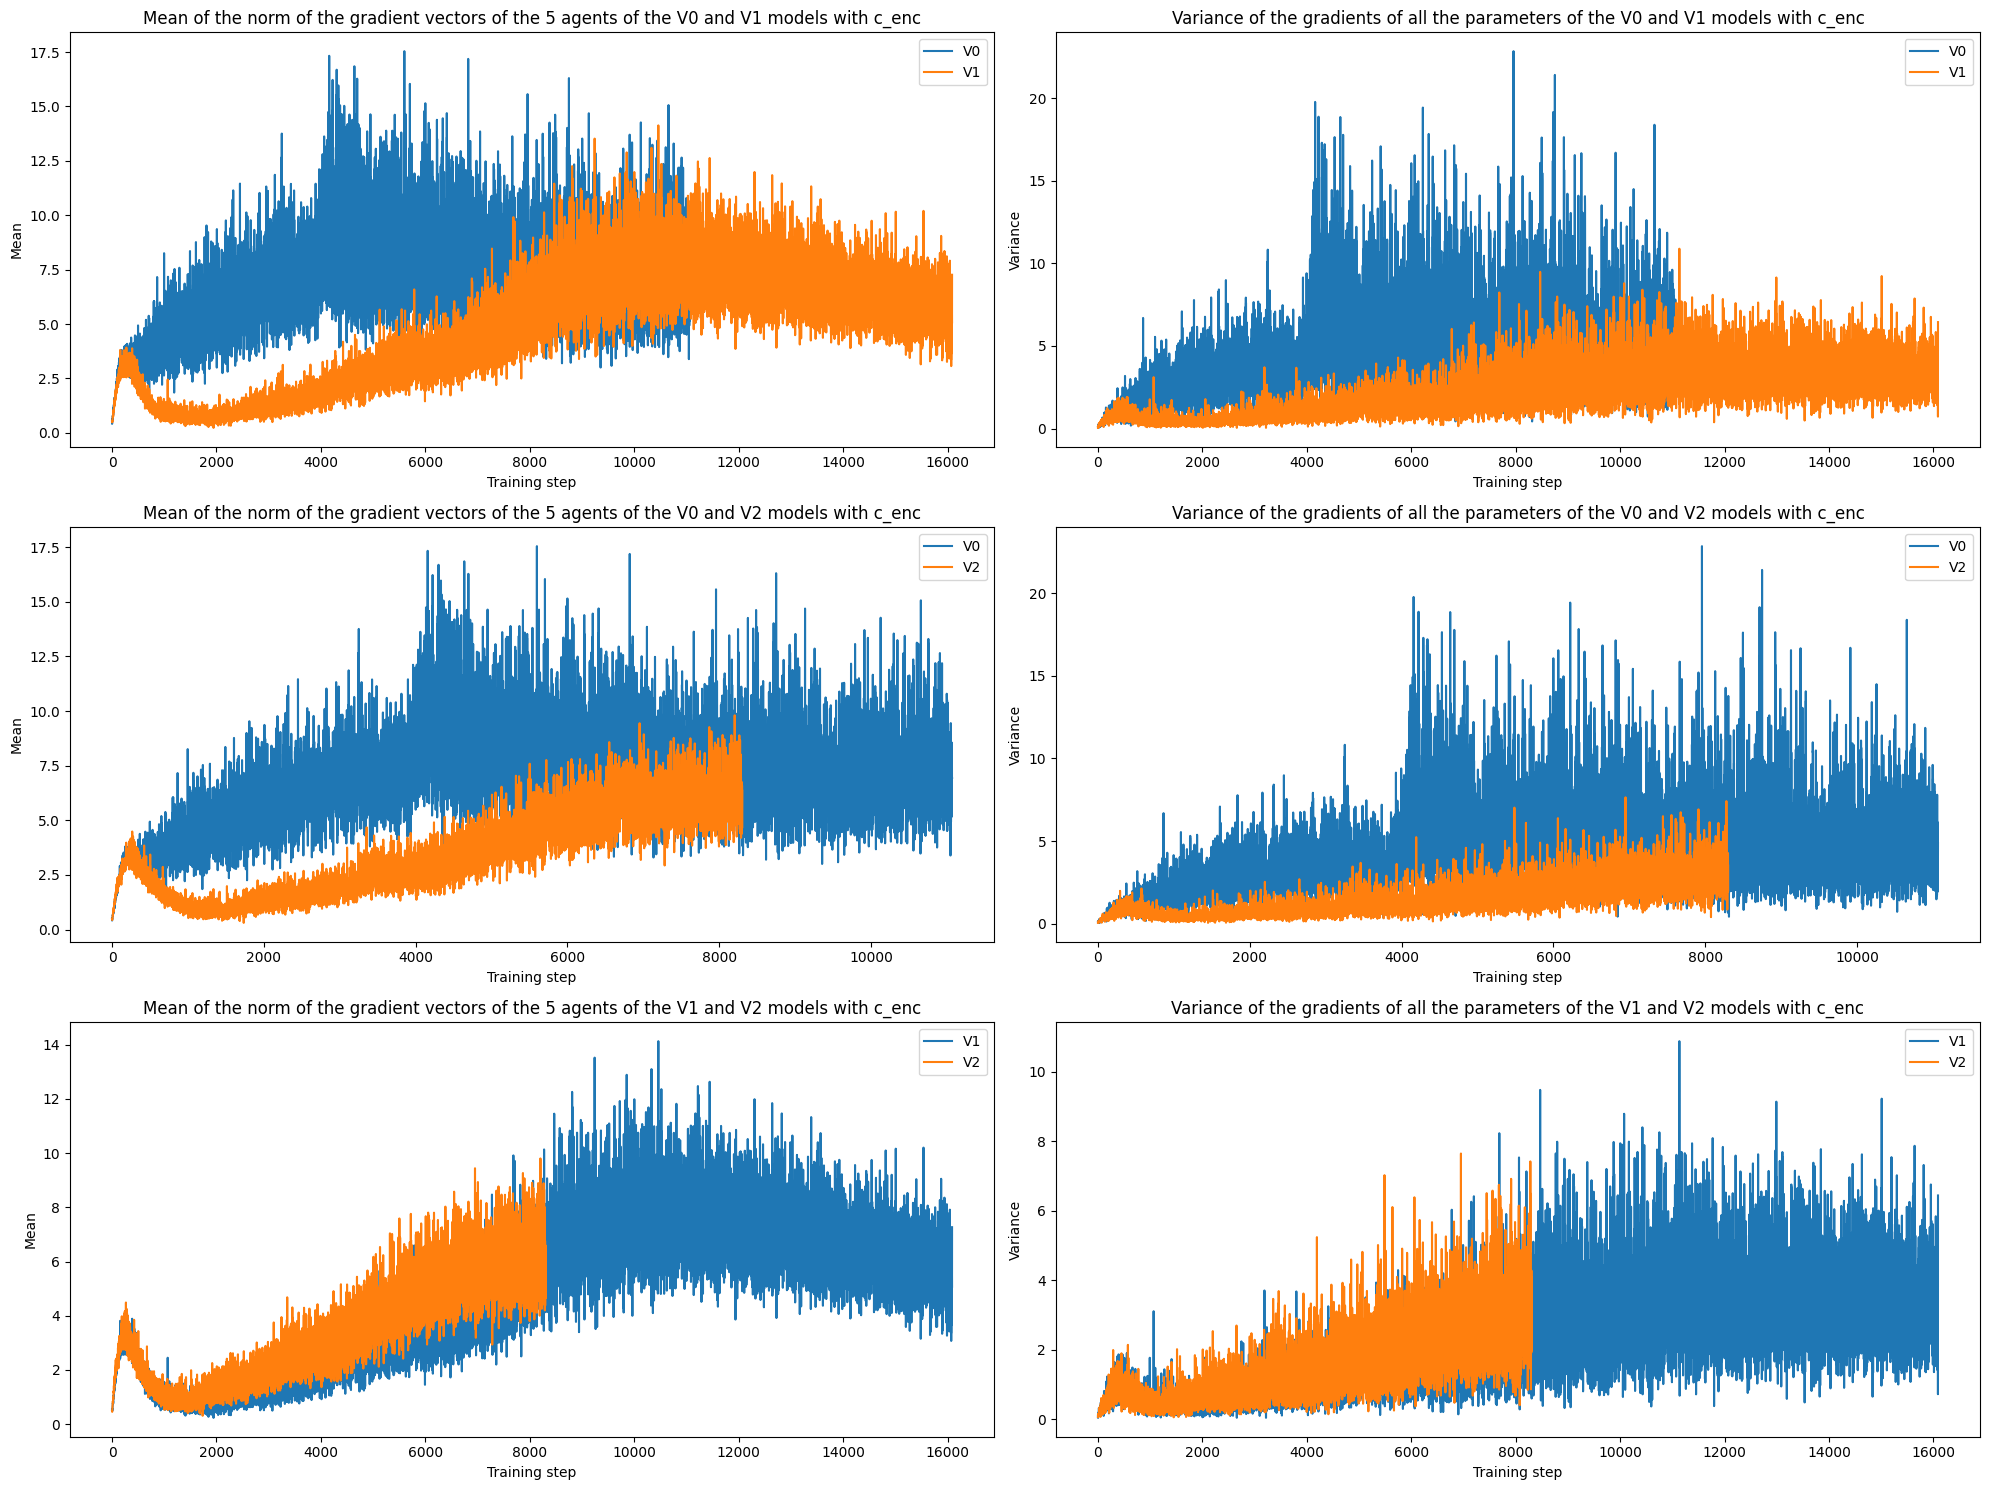

In [5]:
#Now let's plot the mean and variance of the gradients for the V0, V1 and V2 models in the same plot

fig, axs = plt.subplots(3,2, tight_layout=True, figsize=(20, 15))

axs[0,0].set_title("Mean of the norm of the gradient vectors of the 5 agents of the V0 and V1 models with c_enc")
axs[0,0].set_xlabel("Training step")
axs[0,0].set_ylabel("Mean")
axs[0,0].plot(v0_mean, label = "V0")
axs[0,0].plot(v1_mean, label = "V1")
axs[0,0].legend()

axs[0,1].set_title("Variance of the gradients of all the parameters of the V0 and V1 models with c_enc")
axs[0,1].set_xlabel("Training step")
axs[0,1].set_ylabel("Variance")
axs[0,1].plot(v0_variance, label = "V0")
axs[0,1].plot(v1_variance, label = "V1")
axs[0,1].legend()




axs[1,0].set_title("Mean of the norm of the gradient vectors of the 5 agents of the V0 and V2 models with c_enc")
axs[1,0].set_xlabel("Training step")
axs[1,0].set_ylabel("Mean")
axs[1,0].plot(v0_mean, label = "V0")
axs[1,0].plot(v2_mean, label = "V2")
axs[1,0].legend()

axs[1,1].set_title("Variance of the gradients of all the parameters of the V0 and V2 models with c_enc")
axs[1,1].set_xlabel("Training step")
axs[1,1].set_ylabel("Variance")
axs[1,1].plot(v0_variance, label = "V0")
axs[1,1].plot(v2_variance, label = "V2")
axs[1,1].legend()




axs[2,0].set_title("Mean of the norm of the gradient vectors of the 5 agents of the V1 and V2 models with c_enc")
axs[2,0].set_xlabel("Training step")
axs[2,0].set_ylabel("Mean")
axs[2,0].plot(v1_mean, label = "V1")
axs[2,0].plot(v2_mean, label = "V2")
axs[2,0].legend()

axs[2,1].set_title("Variance of the gradients of all the parameters of the V1 and V2 models with c_enc")
axs[2,1].set_xlabel("Training step")
axs[2,1].set_ylabel("Variance")
axs[2,1].plot(v1_variance, label = "V1")
axs[2,1].plot(v2_variance, label = "V2")
axs[2,1].legend()

plt.show()

Now, the difference between what I'm doing and what Skolik is doing in terms of input encoding is that I am doing $\tilde{x_i} = \arctan(x_i)\cdot w_i$ while they do $\tilde{x_i} = \arctan(x_i\cdot w_i)$. This shouldn't make much difference in the end, because the weights are trainable, however the major difference between our methods is that Skolik's features will always be between $[-\pi/2,\pi/2]$ while mine will be between $[-\pi/2,\pi/2]\cdot w_i$. Usually, in machine learning, the features should be of the same scale and I am wondering if it makes a big difference, even though I don't think it does.

In [39]:
c_v0_weights = [c_v0[i]["weights"] for i in range(5)]
c_v1_weights = [c_v1[i]["weights"] for i in range(5)]
c_v2_weights = [c_v2[i]["weights"] for i in range(5)]

n_v0_weights = [n_v0[i]["weights"] for i in range(4)]
n_v1_weights = [n_v1[i]["weights"] for i in range(4)]
n_v2_weights = [n_v2[i]["weights"] for i in range(4)]

In [44]:
#Let's just stay with the input weights which are the second element of the list
c_v0_input_weights = [c_v0_weights[i][1] for i in range(5)]
c_v1_input_weights = [c_v1_weights[i][1] for i in range(5)]
c_v2_input_weights = [c_v2_weights[i][1] for i in range(5)]

n_v0_input_weights = [n_v0_weights[i][1] for i in range(4)]
n_v1_input_weights = [n_v1_weights[i][1] for i in range(4)]
n_v2_input_weights = [n_v2_weights[i][1] for i in range(4)]

In [47]:
n_v0_input_weights

[array([1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32)]

In [48]:
c_v0_input_weights

[array([1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32)]

It makes sense that the input weights of the baseline models are all 1, since these models do not require input scaling, since they dont use data reuploading.

In [49]:
n_v1_input_weights

[array([ 4.3243494e+00,  2.3965819e-03,  2.9832826e+00, -1.2164574e-01,
         8.0220271e-03,  3.8943741e-01,  2.4737105e+00,  5.0175893e-01,
        -2.0363575e-01,  1.9807939e-01,  2.2112088e+00,  3.4351620e-01,
        -2.2387210e-01,  5.2677059e-01,  1.2226626e+00,  1.2529355e-01,
         4.1180995e-01,  1.7955832e-02, -3.4819278e-01,  1.3207911e-01],
       dtype=float32),
 array([ 3.1482568 , -0.0511893 ,  3.6906123 ,  0.0543275 ,  5.825118  ,
        -0.04806578,  1.1639153 , -0.2589719 ,  0.4938127 , -0.21863054,
         3.1132352 ,  0.3335201 ,  0.26399028,  0.24145885,  7.0120854 ,
        -0.18564372,  0.08727624,  1.0261194 , -2.5269778 ,  0.5350166 ],
       dtype=float32),
 array([ 0.84500104,  0.05531688,  1.8284488 , -0.07249123, -0.04376748,
         0.43205908,  1.2384647 ,  0.31958416,  1.1547089 ,  0.20730668,
        -0.3926724 ,  0.01142509,  1.5166968 ,  0.2643452 , -0.35578114,
        -0.09647014,  1.2879994 ,  0.32682174,  1.7106577 ,  0.10334004],
       

In [50]:
c_v1_input_weights

[array([ 3.0689762 ,  0.18529837,  3.059392  , -0.06398388,  5.1794744 ,
         0.16528518,  6.152466  , -0.06605243, -0.9341291 ,  0.20066537,
        -1.7892358 ,  0.04874412,  1.183001  ,  0.2606666 ,  2.48151   ,
         0.08938134,  0.47845328,  0.1134035 ,  0.5584285 ,  0.39580688],
       dtype=float32),
 array([-4.1131105 , -0.0353256 ,  1.2941545 , -0.14131314,  4.0175505 ,
         0.6355274 ,  3.6600008 ,  0.7938823 ,  3.0007565 , -0.1158586 ,
         1.8083287 ,  0.37675196,  4.620757  ,  0.26872447,  4.6920857 ,
        -0.5667919 ,  1.3488365 ,  0.43011397,  2.4880965 , -0.04511758],
       dtype=float32),
 array([ 0.42769685,  0.1011419 ,  1.0442895 ,  0.34208852,  0.04491796,
         0.4916489 ,  1.3934747 ,  0.30390936, -0.3424521 ,  0.25838256,
         1.9879444 ,  0.3994448 , -0.1368034 ,  0.05126489, -0.24196571,
        -0.00559321,  0.06511781,  0.7759296 ,  1.3375766 ,  0.02700634],
       dtype=float32),
 array([ 0.17544258,  0.24674933,  2.714093  ,  0.11

It doesn't make sense to analyse the weights because they don't give us much info into what is happening.